In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
excel_file = pd.ExcelFile("Attached.xlsx")

sheet_name = excel_file.sheet_names

male_df = pd.read_excel('Attached.xlsx', sheet_name='Male Fetal Detection Data')
female_df = pd.read_excel('Attached.xlsx', sheet_name='Female Fetal Detection Data')


male_df['Fetal_Sex'] = 'male'# 为男胎数据添加性别标签
female_df['Fetal_Sex'] = 'female'# 为女胎数据添加性别标签
df = pd.concat([male_df, female_df], ignore_index=True)


df['abnormal'] = df['Chromosomal Aneuploidy'].notna().astype(int)
# - 'Chromosomal Aneuploidy'列记录21、18、13号染色体非整倍体异常（如21三体）
# - .notna()：非空值→True（表示存在异常），空值→False（表示正常）
# - .astype(int)：将True转为1（异常），False转为0（正常）

if 'Z-score of Chromosome Y' not in df.columns:
    df['Z-score of Chromosome Y'] = np.nan# 女性无Y染色体，补充该列并填充NaN
if 'Concentration of Chromosome Y' not in df.columns:
    df['Concentration of Chromosome Y'] = np.nan# 同理补充Y染色体浓度列
# 女性胎儿无Y染色体
# 补充这些列并填充NaN，确保男女数据特征列一致

df['Pregnant Woman\'s BMI'] = df['Pregnant Woman\'s BMI'].fillna(
    df['Pregnant Woman\'s BMI'].median())
# 处理BMI缺失值：
# - 女性数据中存在1个BMI缺失，用中位数填充（

def convert_gestational_week(week_str):
    try:
        # 处理格式如"16w+3"（16周+3天）的孕周字符串
        weeks, days = week_str.replace('w', '').split('+')# 移除"w"，按"+"分割周和天
        return float(weeks) + float(days)/7# 转换为十进制周数（如3天=3/7≈0.43周）
    except:
        return np.nan# 格式异常（如"23w"）返回NaN（后续可进一步清洗）

df['Gestational_Week_Decimal'] = df['Gestational Week at Testing'].apply(
    convert_gestational_week)
    # 孕周转换为数值型：



df['Number of Pregnancies'] = pd.to_numeric(df['Number of Pregnancies'], errors='coerce')
df['Number of Pregnancies'] = df['Number of Pregnancies'].clip(upper=3)


def convert_date_to_int(date_val):
    if pd.isna(date_val):
        return 0 # 缺失值返回0
    if isinstance(date_val, datetime):
        return int(date_val.strftime('%Y%m%d'))# datetime格式→YYYYMMDD整数（如20230510）
    if isinstance(date_val, str):
        try:
            # 字符串尝试解析为日期后转整数
            return int(pd.to_datetime(date_val).strftime('%Y%m%d'))
        except:
            # 若已是YYYYMMDD格式字符串，直接转整数
            try:
                return int(date_val)
            except:
                return 0# 无法转换的字符串返回0
    if isinstance(date_val, (int, float)):
        return int(date_val)# 数值型直接转整数
    return 0# 其他情况返回0

df['Last_Menstrual_Period_Int'] = df['Last Menstrual Period'].apply(convert_date_to_int)
df['Test_Date_Int'] = df['Test Date'].apply(convert_date_to_int)
# 日期转换为整数：

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# 筛选所有数值型特征（如X染色体Z值、GC含量、测序读数、BMI等）

exclude_cols = ['Serial Number', 'abnormal', 'Last_Menstrual_Period_Int', 'Test_Date_Int']
num_cols = [col for col in num_cols if col not in exclude_cols]
# 排除无需标准化的列：
# - 'Serial Number'（样本编号，无实际意义）
# - 'abnormal'（目标变量，无需标准化）
# - 转换后的日期列（保留原始量级更有意义）

scaler = StandardScaler()# 初始化标准化器（将数据缩放到均值=0，标准差=1）
df_std = df.copy()
df_std[num_cols] = scaler.fit_transform(df[num_cols])


cat_vars = ['IVF Pregnancy', 'Whether the Fetus is Healthy', 'Fetal_Sex']
# 定义需编码的分类变量：
# - 'IVF Pregnancy'（受孕方式：自然受孕/IVF，可能影响胎盘功能及胎儿DNA释放）
# - 'Whether the Fetus is Healthy'（胎儿健康状态，辅助验证异常标签）
# - 'Fetal_Sex'（性别，后续筛选女性样本时使用）

df_processed = pd.get_dummies(df_std, columns=cat_vars, drop_first=True)


df_processed.columns


Index(['Serial Number', 'Pregnant Woman Code', 'Age', 'Height', 'Weight',
       'Last Menstrual Period', 'Test Date',
       'Number of Blood Draws for Testing', 'Gestational Week at Testing',
       'Pregnant Woman's BMI', 'Number of Raw Reads',
       'Alignment Rate to Reference Genome', 'Proportion of Duplicate Reads',
       'Number of Uniquely Aligned Reads', 'GC Content',
       'Z-score of Chromosome 13', 'Z-score of Chromosome 18',
       'Z-score of Chromosome 21', 'Z-score of Chromosome X',
       'Z-score of Chromosome Y', 'Concentration of Chromosome Y',
       'Concentration of Chromosome X', 'GC Content of Chromosome 13',
       'GC Content of Chromosome 18', 'GC Content of Chromosome 21',
       'Proportion of Filtered Reads', 'Chromosomal Aneuploidy',
       'Number of Pregnancies', 'Number of Deliveries', 'Unnamed: 20',
       'Unnamed: 21', 'abnormal', 'Gestational_Week_Decimal',
       'Last_Menstrual_Period_Int', 'Test_Date_Int', 'IVF Pregnancy_IVF',
       'IVF P

In [37]:

female_data = df_processed[df_processed['Fetal_Sex_male'] == 0].copy()
# 从预处理数据中筛选女性胎儿样本：


feature_columns = [
    # 核心染色体异常检测指标
    'Z-score of Chromosome 13', # 13号染色体Z值
    'Z-score of Chromosome 18', # 18号染色体Z值
    'Z-score of Chromosome 21', # 21号染色体Z值
    'Z-score of Chromosome X',# X染色体Z值
    
     # GC含量相关特征
    'GC Content', 
    'GC Content of Chromosome 13',# 13号染色体特定GC含量
    'GC Content of Chromosome 18',# 18号染色体特定GC含量
    'GC Content of Chromosome 21',# 21号染色体特定GC含量

    # 测序数据量与质量指标
    'Number of Raw Reads', # 原始测序读段数
    'Proportion of Filtered Reads',# 过滤后读段比例
    'Proportion of Duplicate Reads', # 重复读段比例
    'Number of Uniquely Aligned Reads', # 唯一比对到参考基因组的读段数

    # 孕妇临床特征
    'Pregnant Woman\'s BMI'# 孕妇BMI
]


X = female_data[feature_columns]


y = female_data['abnormal']


In [38]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)


In [39]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(class_weight='balanced_subsample', 
# 平衡类别权重：根据样本中各类别比例自动调整权重
    # 关键原因：女性胎儿异常样本（y=1）占比低，
    # 不平衡的权重会导致模型偏向预测多数类（正常样本），可能漏诊异常
    # 'balanced_subsample'模式会给少数类（异常样本）更高权重，提升对异常的识别能力
random_state=13
)

param_grid = {
    'n_estimators': [75,100,125],# 决策树数量    ：75/100/125棵树
    'max_depth': [50],  # 树的最大深度：50层
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [4, 6, 8], # 叶节点最小样本数：4/6/8
    'max_features': ['sqrt', 0.5]  # 减少每棵树的特征空间
}



grid_search = GridSearchCV(
rf, # 基础模型：随机森林
param_grid, # 超参数网格：上述27种组合
cv=5, # 5折交叉验证：将训练集分成5份，轮流用4份训练、1份验证，减少结果波动
scoring='recall',# 评分标准：召回率（Recall = 真阳性 / (真阳性+假阴性)）
n_jobs=-1# 并行计算：使用所有可用CPU核心加速搜索（处理27种配置×5折验证）
)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_ 

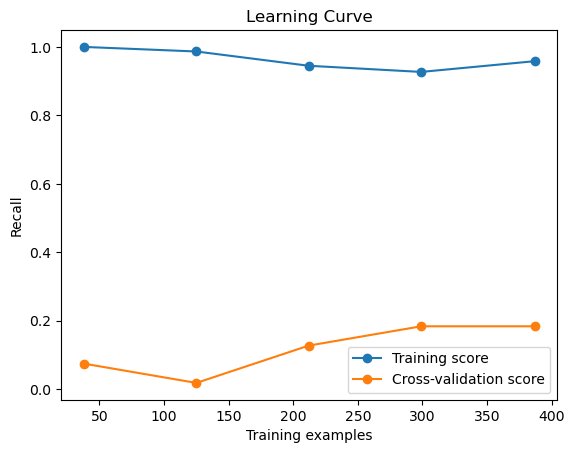

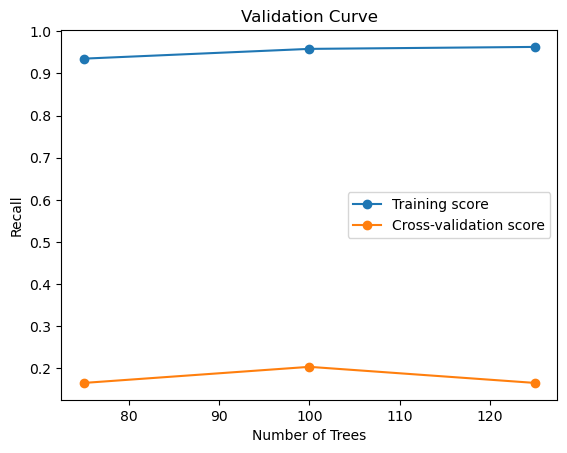

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve


# 生成学习曲线
train_sizes, train_scores, test_scores = learning_curve(
    best_rf, # 待评估的模型：使用之前通过网格搜索筛选出的最优随机森林模型
    X_train, # 训练特征数据（包含染色体Z值、测序质量指标等）
    y_train, # 训练标签（1=异常，0=正常）
    cv=5, # 5折交叉验证：将训练集分成5份，轮流用4份训练、1份验证
    scoring='recall',  # 评估指标：召回率（真阳性率），优先保证异常样本不被漏诊
    n_jobs=-1,# 并行计算
    train_sizes=np.linspace(0.1, 1.0, 5)# 训练样本比例梯度：从10%到100%均匀取5个点
)

plt.figure() 
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning Curve')# 图表标题：学习曲线
plt.xlabel('Training examples')# x轴标签：训练样本数量
plt.ylabel('Recall')# y轴标签：召回率
plt.legend()
plt.show()


param_range = [75,100,125]# 超参数取值范围：决策树数量（与网格搜索保持一致）
train_scores, test_scores = validation_curve(
    best_rf,  # 基础模型：最优随机森林
    X_train,  # 训练特征数据
    y_train,  # 训练标签
    param_name='n_estimators', # 待评估的超参数：随机森林中决策树的数量
    param_range=param_range, # 超参数的具体取值
    cv=5, # 5折交叉验证
    scoring='recall', # 评估指标：召回率
    n_jobs=-1 # 并行计算加速
)


plt.figure()
# 绘制训练集召回率曲线：随决策树数量变化的训练分数均值
plt.plot(param_range, np.mean(train_scores, axis=1), 'o-', label='Training score')
# 绘制验证集召回率曲线：随决策树数量变化的验证分数均值
plt.plot(param_range, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Validation Curve')# 图表标题：验证曲线
plt.xlabel('Number of Trees')# x轴标签：决策树数量
plt.ylabel('Recall')# y轴标签：召回率
plt.legend()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       108
           1       0.44      0.31      0.36        13

    accuracy                           0.88       121
   macro avg       0.68      0.63      0.65       121
weighted avg       0.87      0.88      0.87       121

AUC-ROC: 0.7386


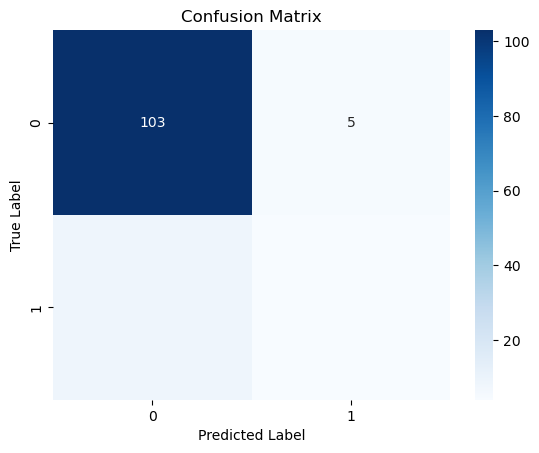

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import seaborn as sns

# 模型预测
y_pred = best_rf.predict(X_test)# 对测试集进行类别预测：输出0（正常）或1（异常）
y_proba = best_rf.predict_proba(X_test)[:, 1]# 对测试集进行概率预测：取预测为异常（1）的概率


print("Classification Report:")
print(classification_report(y_test, y_pred))


print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")# 输出ROC-AUC分数


# 绘制混淆矩阵
cm = confusion_matrix(y_test, y_pred)# 计算混淆矩阵：行=真实标签，列=预测标签


plt.figure()# 创建画布
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')# 绘制热图：
plt.title('Confusion Matrix')# 标题：混淆矩阵
plt.ylabel('True Label')# y轴标签：真实标签（0=正常，1=异常）
plt.xlabel('Predicted Label')# x轴标签：预测标签（0=正常，1=异常）
plt.show()

# 对0来说
#  precision=0.92，很好
#  recall= 0.95，十分优秀
#  F1-score=0.94，综合表现优异

# 对1来说
#  precision=0.44，较低
#  recall=0.31，拉中拉
#  F1-score=0.36，整体偏低

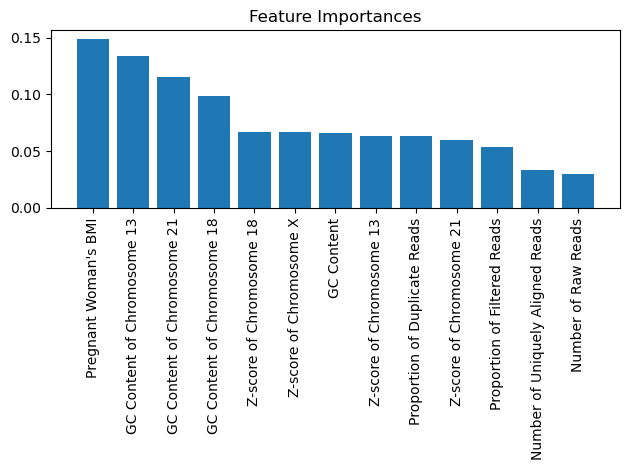

In [ ]:

importances = best_rf.feature_importances_
# 得分范围0~1，总和为1：得分越高，该特征对模型区分"正常/异常"样本的作用越大

indices = np.argsort(importances)[::-1]
# [::-1]：将索引反转，得到按重要性从大到小排序的索引（便于从左到右绘制条形图）


plt.figure()# 创建新画布
plt.title('Feature Importances')# 图表标题：特征重要性
plt.bar(range(X.shape[1]), importances[indices])
# 设置x轴刻度标签：使用排序后的特征名称，旋转90度避免长名称重叠
plt.xticks(range(X.shape[1]), [feature_columns[i] for i in indices], rotation=90)
plt.tight_layout()# 自动调整布局，避免标签被截断
plt.show()



# 诊断模型问题：
#  需调整模型参数。
# 可能需更多数据，尤其是异常样本。
# 过拟合严重